In [1]:
# ================================================================
#  CEO Compensation Analysis & OLS Regression
#  Author: Shoumik Mehta
#  Purpose: Explore relationships between CEO pay and firm metrics
# ================================================================

# --- 1. Setup & Imports ---
# Install missing packages (safe to re-run)
!pip -q install statsmodels

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from google.colab import files

# Create structured output folders for GitHub repo
os.makedirs("figures", exist_ok=True)
os.makedirs("report", exist_ok=True)

# Configure plot style
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True


In [8]:
# --- 2. Upload Datasets ---
# Upload the two CSVs: companies_2025_s1.csv & salaries_2025_s1.csv
uploaded = files.upload()
list(uploaded.keys())

# --- 3. Load & Merge Data ---
companies = pd.read_csv("Companies_2025.csv")
salaries  = pd.read_csv("salaries_2025.csv")

# Display basic info
print("Companies dataset:", companies.shape)
print("Salaries dataset:", salaries.shape)

# Drop incomplete rows
companies = companies.dropna(subset=["CompanyID","Firm_Size","Profitability","Industry"])
salaries  = salaries.dropna(subset=["CompanyID","CEO_Salary"])

# Merge on CompanyID
df = salaries.merge(companies, on="CompanyID", how="inner")
print("Merged dataset:", df.shape)
df.head()



Saving salaries_2025.csv to salaries_2025 (1).csv
Saving Companies_2025.csv to Companies_2025 (1).csv
Companies dataset: (1000, 4)
Salaries dataset: (1000, 2)
Merged dataset: (1000, 5)


,CompanyID,CEO_Salary,Firm_Size,Profitability,Industry
0,1,5932729,29094,0.0834,Finance
1,2,1048620,71953,0.1149,Energy
2,3,602067,1370,0.1870,Energy
3,4,2984336,10352,0.0976,Technology
4,5,1797061,69802,0.1391,Energy


In [9]:
# --- 4. Summary Statistics ---
summary_stats = df[["CEO_Salary", "Firm_Size", "Profitability"]].describe()
summary_stats


,CEO_Salary,Firm_Size,Profitability
count,1.000000e+03,1000.000000,1000.000000
mean,5.115838e+06,50947.564000,0.154059
std,2.942817e+06,28629.197658,0.085837
min,1.234880e+05,1163.000000,0.000100
25%,2.449064e+06,27710.000000,0.081925
50%,5.165543e+06,50655.000000,0.155100
75%,7.657207e+06,76220.000000,0.228075
max,9.993121e+06,99914.000000,0.299700


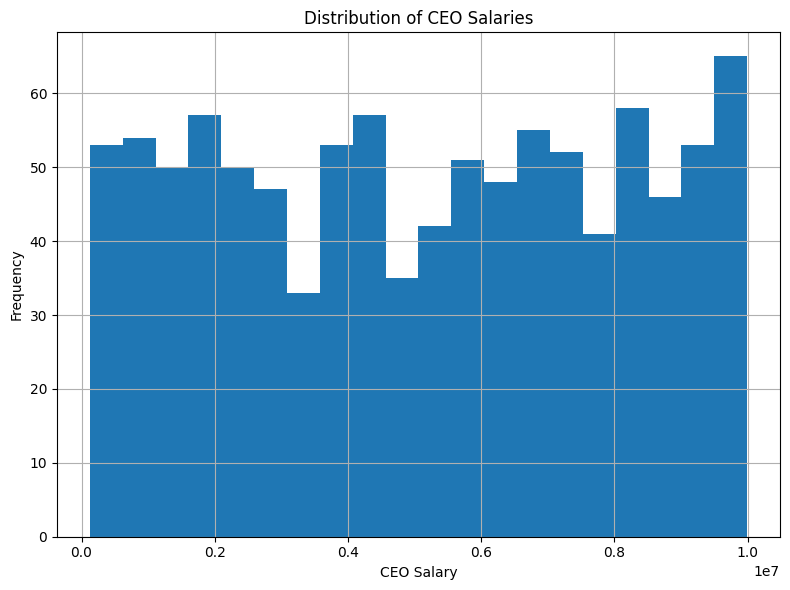

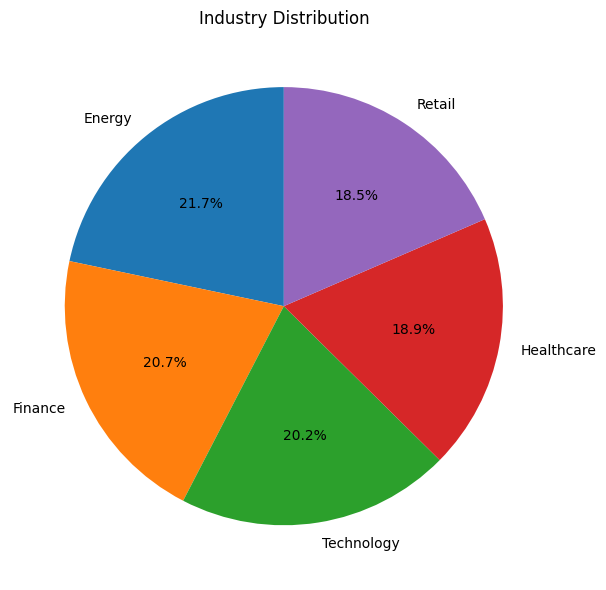

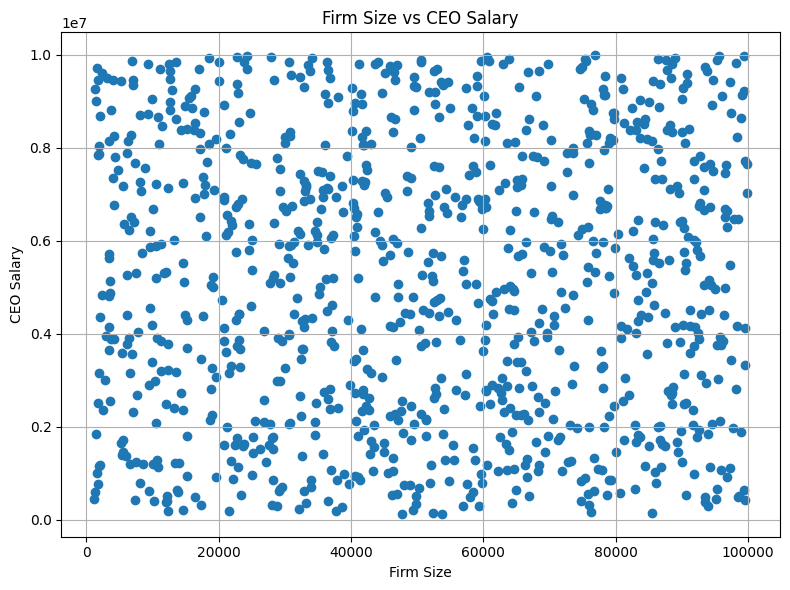

In [10]:
# --- 5. Data Visualisation ---
# Histograms, pie charts, scatter plots for exploratory analysis
# All figures saved in /figures (auto-ready for GitHub push)

# CEO Salary distribution
plt.hist(df["CEO_Salary"], bins=20)
plt.title("Distribution of CEO Salaries")
plt.xlabel("CEO Salary")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figures/ceo_salary_hist.png")
plt.show()

# Industry distribution pie chart
df["Industry"].value_counts().plot(kind="pie", autopct="%1.1f%%", startangle=90, ylabel="")
plt.title("Industry Distribution")
plt.tight_layout()
plt.savefig("figures/industry_distribution_pie.png")
plt.show()

# Firm size vs CEO Salary scatter plot
plt.scatter(df["Firm_Size"], df["CEO_Salary"])
plt.title("Firm Size vs CEO Salary")
plt.xlabel("Firm Size")
plt.ylabel("CEO Salary")
plt.tight_layout()
plt.savefig("figures/firm_size_vs_ceo_salary.png")
plt.show()


In [11]:
# --- 6. Winsorization of CEO Salary ---
# Handle outliers at 1% tails to avoid skewed regression estimates

df["CEO_Salary_W"] = np.asarray(
    winsorize(df["CEO_Salary"], limits=[0.01, 0.01])
).astype(float)

# Compare pre/post treatment
pre_stats  = df["CEO_Salary"].describe()
post_stats = df["CEO_Salary_W"].describe()
comparison = pd.DataFrame({"Before": pre_stats, "After": post_stats})
comparison


,Before,After
count,1.000000e+03,1.000000e+03
mean,5.115838e+06,5.116077e+06
std,2.942817e+06,2.941082e+06
min,1.234880e+05,2.290400e+05
25%,2.449064e+06,2.449064e+06
50%,5.165543e+06,5.165543e+06
75%,7.657207e+06,7.657207e+06
max,9.993121e+06,9.920211e+06


In [12]:
# --- 7. OLS Regression ---
# Dependent variable: Winsorized CEO Salary
# Independent variables: Firm Size, Profitability

X = df[["Firm_Size", "Profitability"]]
X = sm.add_constant(X)
y = df["CEO_Salary_W"]

model = sm.OLS(y, X).fit()
print(model.summary())

# Save regression output to /report (GitHub-ready)
with open("report/OLS_regression_summary.txt", "w") as f:
    f.write(model.summary().as_text())

# Also save processed dataset for reproducibility
df.to_csv("report/merged_dataset_with_winsorized_salary.csv", index=False)


                            OLS Regression Results                            
Dep. Variable:           CEO_Salary_W   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4212
Date:                Tue, 19 Aug 2025   Prob (F-statistic):              0.656
Time:                        00:13:38   Log-Likelihood:                -16312.
No. Observations:                1000   AIC:                         3.263e+04
Df Residuals:                     997   BIC:                         3.265e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.239e+06   2.55e+05     20.577